In [1]:
import scipy as sp
import numpy as np
import seaborn as sns
import mne
import os
import pandas as pd
%matplotlib inline
from scipy import signal
from scipy.signal import butter,filtfilt,firwin

In [2]:
def draw_plot(signal,title,xtext,ytext):
    sns.plt.title(title)
    sns.plt.plot(signal['time'].values,signal['EMGZ'])
    sns.plt.xlabel(xtext)
    sns.plt.ylabel(ytext)

In [3]:
def detrend_signal(signal_data_):
    d_signal = signal_data_.copy()
    d_signal['EMGZ'] = signal.detrend(signal_data_['EMGZ'].values)
    return d_signal

In [4]:
def rec_signal(signal_data_):
    rec_signal = signal_data_.copy()
    rec_signal['EMGZ'] = signal_data_['EMGZ'].apply(lambda x: abs(x))
    return rec_signal

In [5]:
def apply_bandpass_filter(signal_data_,freq = 10000,lfreq = 10,hfreq = 400, order=2):
    flt_signal = signal_data_.copy()
    signal_value = signal_data_['EMGZ'].values
    nyq = 0.5 * freq
    b, a = butter(order, [lfreq/nyq,hfreq/nyq], btype = 'bandpass')
    flt_value = filtfilt(b, a, signal_value)
    flt_signal['EMGZ'] = flt_value 
    return flt_signal

In [6]:
def apply_iir_filter(signal_data_,cutoff = 8, order=2,btype =  'low'):
    flt_signal = signal_data_.copy()
    time = signal_data_['time'].values
    freq = 1/(np.mean(np.diff(time))*0.001)
    print(freq)
    signal_value = signal_data_['EMGZ'].values
    nyq = 0.5 * freq
    normal_cutoff = cutoff / nyq
    # Use Butterworth iir_fiter.
    b, a = butter(order, normal_cutoff, btype = btype)
    flt_value = filtfilt(b, a, signal_value)
    flt_signal['EMGZ'] = flt_value 
    return flt_signal

In [7]:
def apply_fir_filter(signal_data_,cutoff = 8, N=1001, order=2,btype =  'low'):
    flt_signal = signal_data_.copy()
    time = signal_data_['time'].values
    freq = 1/(np.mean(np.diff(time))*0.001)
    print(freq)
    signal_value = signal_data_['EMGZ'].values
    nyq = 0.5 * freq
    normal_cutoff = cutoff / nyq
    is_lowpass = btype == 'low'
    b = firwin(N, cutoff=normal_cutoff, window='hamming',pass_zero = is_lowpass)    
    flt_value = filtfilt(b, 1.0, signal_value)
    flt_signal['EMGZ'] = flt_value 
    return flt_signal

In [8]:
root_dir = '../data'

In [9]:
edf_path = os.path.join(root_dir,'NeoRec_2016-08-15_15-47-26.edf')

In [10]:
edf_path

'../data\\NeoRec_2016-08-15_15-47-26.edf'

In [11]:
edf_signal = mne.io.read_raw_edf(edf_path,preload=True)

Extracting edf Parameters from ../data\NeoRec_2016-08-15_15-47-26.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 482499  =      0.000 ...   964.998 secs...
Ready.


In [12]:
edf_data_frame = edf_signal.to_data_frame()

Converting time column to int64...


In [13]:
edf_data_frame.head()

signal,GSR,PPG,EMGZ,EMGC,Fp1,Fp2,Fz,F3,F4,A1,A2,STI 014
time,,,,,,,,,,,,
0,2.648966,2.648966,3.511437,3.511437,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.0
2,2.648966,2.648966,3.511437,3.511437,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.0
4,2.648966,2.648966,3.511437,3.511437,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.0
6,2.648966,2.648966,3.511437,3.511437,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.0
8,2.648966,2.648966,3.511437,3.511437,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.004414,0.0


In [14]:
edf_data_frame['time'] = edf_data_frame.index.values
emg_signal = edf_data_frame[['time','EMGZ']]
edf_data_frame.drop('time',axis=1,inplace=True)

In [15]:
## Очиститка сигнала от постоянного амплитудного смещения
emg_detrend_signal = detrend_signal(emg_signal)

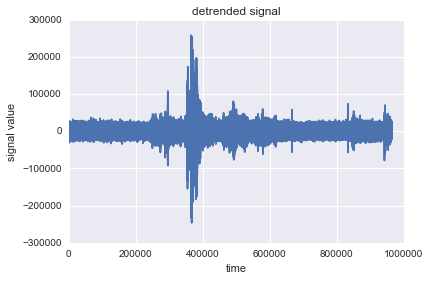

In [16]:
draw_plot(emg_detrend_signal,'detrended signal','time','signal value')

In [17]:
emg_flt_signal = apply_bandpass_filter(emg_detrend_signal)

In [18]:
# ректефикация  сигнала
emg_flt_signal = rec_signal(emg_flt_signal)

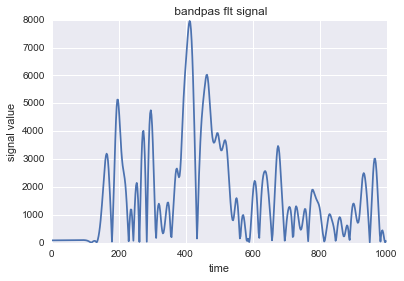

In [19]:
# draw only fist N observations  
draw_plot(emg_flt_signal.head(n=500),' bandpas flt signal','time','signal value')

In [20]:
emg_flt_signal1 = apply_iir_filter(emg_flt_signal,btype = 'low')

500.0


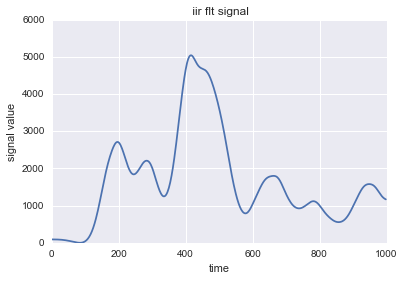

In [21]:
# draw only fist N observations  
draw_plot(emg_flt_signal1.head(n=500),' iir flt signal','time','signal value')

In [22]:
emg_flt_signal2 = apply_fir_filter(emg_flt_signal,btype = 'low')

500.0


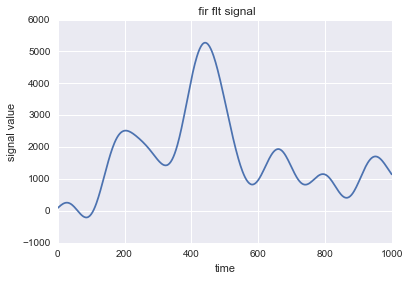

In [23]:
# draw only fist N observations  
draw_plot(emg_flt_signal2.head(n=500),' fir flt signal','time','signal value')